In [ ]:
# !pip install fiftyone
# ! pip install requests pycocotools pillow

In [1]:
# import fiftyone as fo
# import fiftyone.zoo as foz

import cv2
from PIL import Image, ImageDraw
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import skimage.io as io

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T

import torchvision.transforms as transforms
from torchsummary import summary

import math
import json
from tqdm import tqdm
from google.colab import files

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import requests
from io import BytesIO


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and visualize Oxford Town


In [4]:
oxford_annotations = pd.read_csv('/content/drive/MyDrive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])
oxford_annotations.head(5)

,personNumber,frameNumber,headNumber,bodyNumber,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


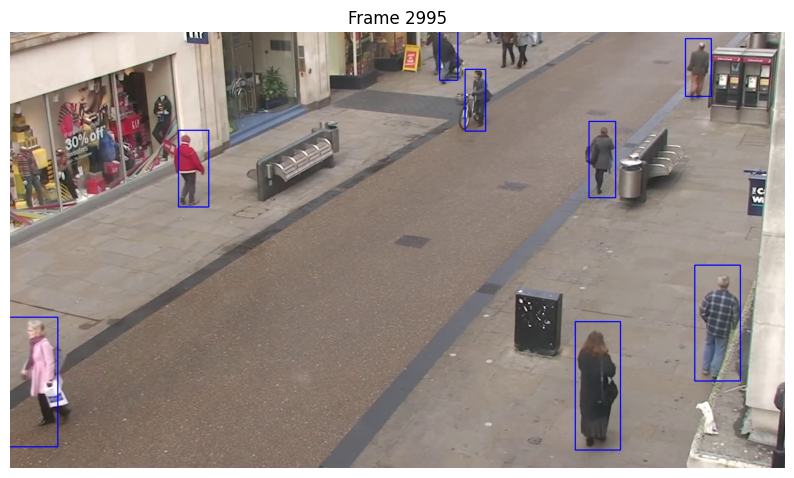

In [5]:
output_dir = '/content/drive/MyDrive/Oxford/Images'

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes):
    for box in boxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color bounding box
    return image

# Visualize images with bounding boxes
frames = oxford_annotations['frameNumber'].unique()
frames10 = frames[2995:2996]
for frame in frames10:
    frame = int(frame)
    image_path = os.path.join(output_dir, f'{frame}.jpg')
    image = cv2.imread(image_path)

    if image is not None:
        # Extract bounding box coordinates for the current frame
        boxes = oxford_annotations[oxford_annotations['frameNumber'] == frame][['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']].values

        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(image, boxes)

        # Convert BGR image to RGB for matplotlib
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Frame {frame}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for frame {frame} not found.")

### Load and visualize COCO

loading annotations into memory...
Done (t=30.80s)
creating index...
index created!


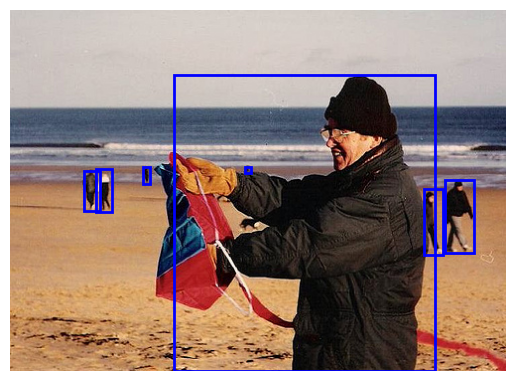

In [6]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"

# Visualize example image
coco = COCO(coco_train_inst_ann_file)
catIds = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catIds)

# Filter images with at least one bounding box annotation
filtered_imgIds = []
for img_id in imgIds:
    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if any(ann['bbox'] for ann in anns):
        filtered_imgIds.append(img_id)

# Initialize random image
random_img_id = random.choice(filtered_imgIds)

# Initialize random image
img = coco.loadImgs(random_img_id)[0]

# Load the image
I = io.imread(img['coco_url'])

fig, ax = plt.subplots()
ax.imshow(I)

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None, catIds=catIds[0])
anns = coco.loadAnns(annIds)

for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(bb)

plt.axis('off')
plt.show()

### Resize oxford images and convert to yolo format

In [20]:
def resize_with_padding(image, target_size):
    # Calculate the scaling factor while preserving aspect ratio
    original_size = image.size
    aspect_ratio = original_size[0] / original_size[1]

    if aspect_ratio > 1:
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new image with the target size and paste the resized image
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    new_image.paste(image, ((target_size - new_width) // 2, (target_size - new_height) // 2))

    padding_x = (target_size - new_width) // 2
    padding_y = (target_size - new_height) // 2

    return new_image, original_size, padding_x, padding_y, new_width, new_height

# def draw_bounding_boxes(image, bounding_boxes):
#     draw = ImageDraw.Draw(image)
#     for box in bounding_boxes:
#         draw.rectangle(box, outline="red", width=1)  # Set width to 1 for thinner lines
#     return image

def clip_bounding_box(box, padding_x, padding_y, new_width, new_height):
    # Clip the bounding box coordinates to the actual image area (excluding padding)
    xmin = max(box[0] + padding_x, padding_x)
    ymin = max(box[1] + padding_y, padding_y)
    xmax = min(box[2] + padding_x, padding_x + new_width)
    ymax = min(box[3] + padding_y, padding_y + new_height)

    # Ensure xmin <= xmax and ymin <= ymax
    xmin = min(xmin, xmax)
    ymin = min(ymin, ymax)

    return (xmin, ymin, xmax, ymax)

def get_bounding_boxes_for_frame(df, frame_number):
    frame_data = df[df['frameNumber'] == frame_number]
    bounding_boxes = []
    for _, row in frame_data.iterrows():
        # Extract the body bounding box coordinates
        box = (row['bodyLeft'], row['bodyTop'], row['bodyRight'], row['bodyBottom'])
        bounding_boxes.append(box)
    return bounding_boxes


def convert_bbox_to_yolo(box, image_width, image_height):
    x_center = (box[0] + box[2]) / 2.0 / image_width
    y_center = (box[1] + box[3]) / 2.0 / image_height
    width = (box[2] - box[0]) / image_width
    height = (box[3] - box[1]) / image_height
    return f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def resize_and_save_all_images(image_dir, df, target_dir, target_size, target_annotation_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    if not os.path.exists(target_annotation_dir):
        os.makedirs(target_annotation_dir)

    img_filenames = sorted(os.listdir(image_dir))
    # img_filenames = img_filenames[:10]

    for img_filename in img_filenames:
        img_path = os.path.join(image_dir, img_filename)
        target_path = os.path.join(target_dir, img_filename)
        annotation_file = os.path.join(target_annotation_dir, os.path.splitext(img_filename)[0] + '.txt')

        try:
            # Extract frame number from the filename (assuming it's part of the filename)
            frame_number = int(os.path.splitext(img_filename)[0])

            # Open image
            image = Image.open(img_path)

            # Get bounding boxes for the current frame
            bounding_boxes = get_bounding_boxes_for_frame(df, frame_number)

            # Resize image and bounding boxes
            resized_image, original_size, padding_x, padding_y, new_width, new_height = resize_with_padding(image, target_size)

            # Scale and clip bounding boxes to match the resized image
            scale_x = new_width / original_size[0]
            scale_y = new_height / original_size[1]

            resized_bounding_boxes = [
                clip_bounding_box(
                    (
                        int(box[0] * scale_x),
                        int(box[1] * scale_y),
                        int(box[2] * scale_x),
                        int(box[3] * scale_y)
                    ),
                    padding_x, padding_y, new_width, new_height
                )
                for box in bounding_boxes
            ]

            # Draw bounding boxes on the resized image
            # resized_image_with_boxes = draw_bounding_boxes(resized_image, resized_bounding_boxes)

            # Save the resized image
            resized_image.save(target_path)
            print(f"Resized and saved {img_filename}")

            yolo_annotations = [
                convert_bbox_to_yolo(box, target_size, target_size)
                for box in resized_bounding_boxes
            ]

            with open(annotation_file, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')
            print(f"{img_filename} converted to YOLO format")

        except Exception as e:
            print(f"Error processing {img_filename}: {e}")


# Load the Oxford annotations
oxford_annotations = pd.read_csv('/content/drive/MyDrive/Oxford/TownCentre-groundtruth.top', names=[
    'personNumber', 'frameNumber', 'headNumber', 'bodyNumber',
    'headLeft', 'headTop', 'headRight', 'headBottom',
    'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'
])

source_dir = '/content/drive/MyDrive/Oxford/Images'  # Source directory
target_dir = '/content/drive/MyDrive/Oxford/imgs_resized'  # Target directory for saving resized images
target_ann_dir = '/content/drive/MyDrive/Oxford/yolo_annotations'
target_size = 128  # Desired size for resizing

# Resize and save all images
resize_and_save_all_images(source_dir, oxford_annotations, target_dir, target_size, target_ann_dir)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Resized and saved 550.jpg
550.jpg converted to YOLO format
Resized and saved 5500.jpg
5500.jpg converted to YOLO format
Resized and saved 5501.jpg
5501.jpg converted to YOLO format
Resized and saved 5502.jpg
5502.jpg converted to YOLO format
Resized and saved 5503.jpg
5503.jpg converted to YOLO format
Resized and saved 5504.jpg
5504.jpg converted to YOLO format
Resized and saved 5505.jpg
5505.jpg converted to YOLO format
Resized and saved 5506.jpg
5506.jpg converted to YOLO format
Resized and saved 5507.jpg
5507.jpg converted to YOLO format
Resized and saved 5508.jpg
5508.jpg converted to YOLO format
Resized and saved 5509.jpg
5509.jpg converted to YOLO format
Resized and saved 551.jpg
551.jpg converted to YOLO format
Resized and saved 5510.jpg
5510.jpg converted to YOLO format
Resized and saved 5511.jpg
5511.jpg converted to YOLO format
Resized and saved 5512.jpg
5512.jpg converted to YOLO format
Resized and saved 5513

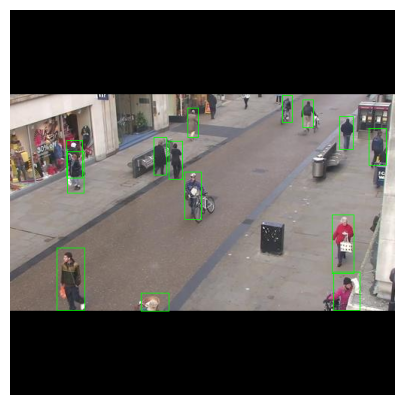

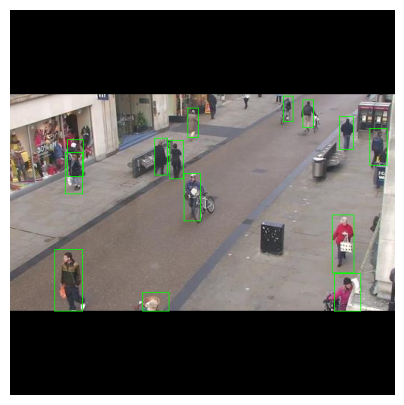

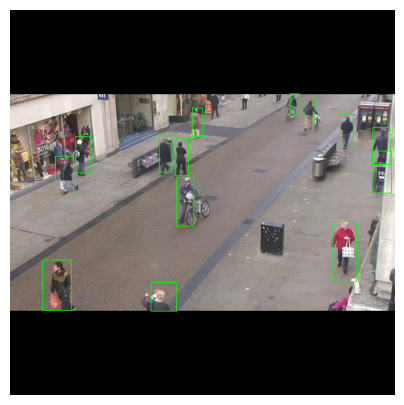

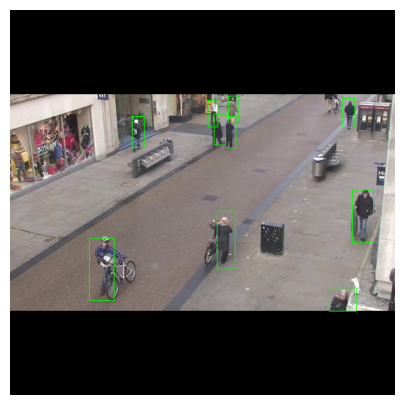

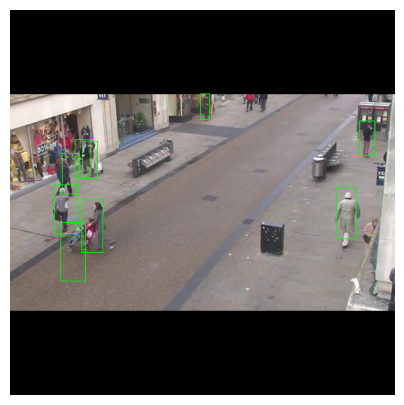

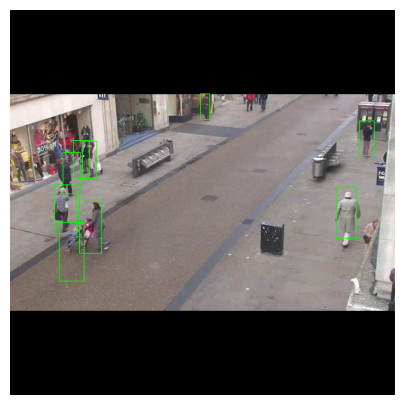

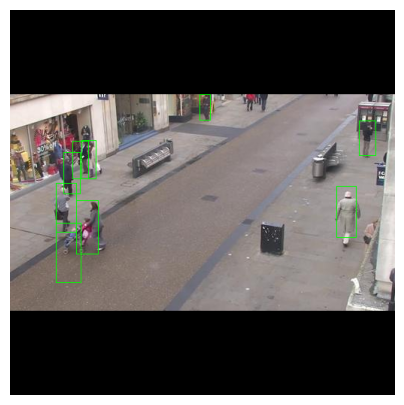

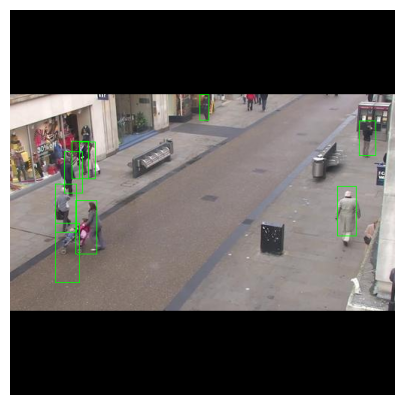

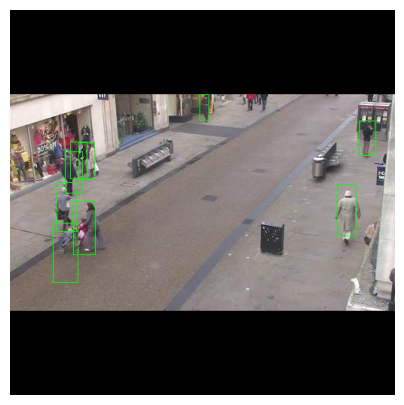

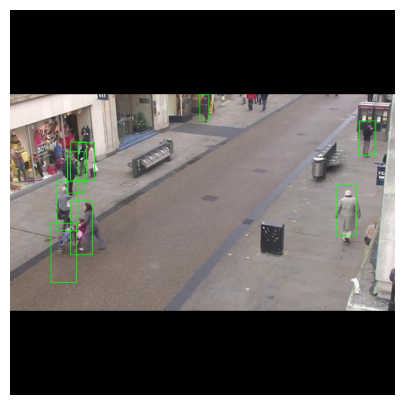

In [18]:
# Check if yolo conversion was successful

# Function to draw bounding boxes on the image
def draw_bboxes(img, bboxes):
    h, w, _ = img.shape
    for bbox in bboxes:
        _, x_center, y_center, bbox_width, bbox_height = bbox

        # Convert YOLO format to bounding box coordinates
        x1 = int((x_center - bbox_width / 2) * w)
        y1 = int((y_center - bbox_height / 2) * h)
        x2 = int((x_center + bbox_width / 2) * w)
        y2 = int((y_center + bbox_height / 2) * h)

        # Draw rectangle without label
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

    return img

# Function to read YOLO annotation files
def read_yolo_file(yolo_file):
    with open(yolo_file, 'r') as file:
        lines = file.readlines()
        bboxes = []
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            bboxes.append((int(class_id), x_center, y_center, width, height))
    return bboxes

# Directory containing the images and annotation files
image_dir = '/content/drive/MyDrive/Oxford/yolo/imgs'
yolo_dir = '/content/drive/MyDrive/Oxford/yolo/ann'

# Process each image
for image_name in os.listdir(image_dir)[:10]:
    if image_name.endswith(('.jpg', '.png')):
        img_path = os.path.join(image_dir, image_name)
        yolo_file = os.path.join(yolo_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        # Read image and annotations
        img = cv2.imread(img_path)
        bboxes = read_yolo_file(yolo_file)

        # Draw bounding boxes on the image
        img_with_bboxes = draw_bboxes(img, bboxes)

        # Display the image
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img_with_bboxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


### Resize, filter and download COCO images

In [ ]:
def filter_image_ids(img_dir, coco, coco_caps, words=None):
    # Initialize the Porter Stemmer
    stemmer = PorterStemmer()
    if words:
        stemmed_words = [stemmer.stem(word) for word in words]
    else:
        stemmed_words = []

    # List downloaded images
    downloaded_imgs = set(os.listdir(img_dir))

    # Get image IDs for images containing people
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)

    filtered_img_ids = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        if img_filename in downloaded_imgs:
            ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            if any(ann['bbox'] for ann in anns):
                if stemmed_words:
                    cap_ids = coco_caps.getAnnIds(imgIds=img_id)
                    caps = coco_caps.loadAnns(cap_ids)
                    for cap in caps:
                        caption = cap['caption'].lower()
                        caption_tokens = word_tokenize(caption)
                        stemmed_caption_tokens = [stemmer.stem(token) for token in caption_tokens]
                        if any(stemmed_word in stemmed_caption_tokens for stemmed_word in stemmed_words):
                            filtered_img_ids.append(img_id)
                            break
                else:
                    filtered_img_ids.append(img_id)

    print(f"Found {len(filtered_img_ids)} images matching criteria.")
    return filtered_img_ids


def resize_with_padding(image, target_size):
    # Resize while maintaining aspect ratio
    image.thumbnail((target_size, target_size), Image.LANCZOS)
    # Create a new image with the target size and paste the resized image
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
    return new_image

def download_and_resize_images(img_ids, coco, target_dir, target_size):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']
        img_filename = img_info['file_name']
        img_path = os.path.join(target_dir, img_filename)

        if not os.path.exists(img_path):
            response = requests.get(img_url)
            image = Image.open(BytesIO(response.content))

            # Resize image
            resized_image = resize_with_padding(image, target_size)
            resized_image.save(img_path)

            print(f"Downloaded and resized {img_filename}")
        else:
            print(f"{img_filename} already exists.")


In [ ]:
# Download either filtered or unfiltered images to test with what kind of data the models perform better

# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# Directory paths (in Colab working directory)
train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'
unfiltered_train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/imgs'
unfiltered_val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/imgs'
filtered_train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/imgs_filtered'
filtered_val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/imgs_filtered'

# Words to filter in captions
words = ['street', 'road', 'city', 'surveillance', 'people', 'pedestrian', 'cctv', 'town', 'crosswalk', 'walking', 'group', 'restaurant', 'bike', 'shop',
        'plaza', 'square', 'sidewalk', 'junction', 'avenue', 'boulevard', 'pathway', 'alley', 'intersection']

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

# All image IDs
# all_train_img_ids = filter_image_ids(train_img_dir, coco_train, coco_train_caps)
# all_val_img_ids = filter_image_ids(val_img_dir, coco_val, coco_val_caps, words)

# Filter image IDs
train_img_ids = filter_image_ids(train_img_dir, coco_train, coco_train_caps, words)
val_img_ids = filter_image_ids(val_img_dir, coco_val, coco_val_caps, words)

# Download unfiltered images
target_size = 128  # Set the target size for resizing
# download_and_resize_images(all_train_img_ids, coco_train, unfiltered_train_img_dir, target_size)
# download_and_resize_images(all_val_img_ids, coco_val, unfiltered_val_img_dir, target_size)

# Download and resize filtered images
download_and_resize_images(train_img_ids, coco_train, filtered_train_img_dir, target_size)
download_and_resize_images(val_img_ids, coco_val, filtered_val_img_dir, target_size)